# **Important Libraries**

In [1]:
import pandas as pd
import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from sklearn.model_selection import train_test_split
from skimage import io
import tifffile as tiff
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# **Prepare Dataset**

In [2]:
img_dir = "/content/drive/MyDrive/data/images"
mask_dir = "/content/drive/MyDrive/data/labels"

In [3]:
len(os.listdir(img_dir)),len(os.listdir(mask_dir))

(306, 456)

In [4]:
# Collect images and masks
images = [os.path.join(img_dir,file) for file in os.listdir(img_dir) if file.endswith('.tif')]
masks = [os.path.join(mask_dir,file) for file in os.listdir(mask_dir) if file.endswith('.png')]

In [5]:
# Create dictionaries to match images with masks
image_names = {os.path.splitext(os.path.basename(img))[0]: img for img in images}
mask_names = {os.path.splitext(os.path.basename(mask))[0]: mask for mask in masks}

# Find common keys
common_keys = sorted(set(image_names) & set(mask_names))

# Ensure only matching images and masks are used
images = [image_names[key] for key in common_keys]
masks = [mask_names[key] for key in common_keys]

# Length of them
print(len(images),len(masks))

306 306


In [6]:
# Create DataFrame
df = pd.DataFrame({"images":images,"masks":masks})
df.head()

,images,masks
0,/content/drive/MyDrive/data/images/0.tif,/content/drive/MyDrive/data/labels/0.png
1,/content/drive/MyDrive/data/images/1.tif,/content/drive/MyDrive/data/labels/1.png
2,/content/drive/MyDrive/data/images/10.tif,/content/drive/MyDrive/data/labels/10.png
3,/content/drive/MyDrive/data/images/100.tif,/content/drive/MyDrive/data/labels/100.png
4,/content/drive/MyDrive/data/images/101.tif,/content/drive/MyDrive/data/labels/101.png


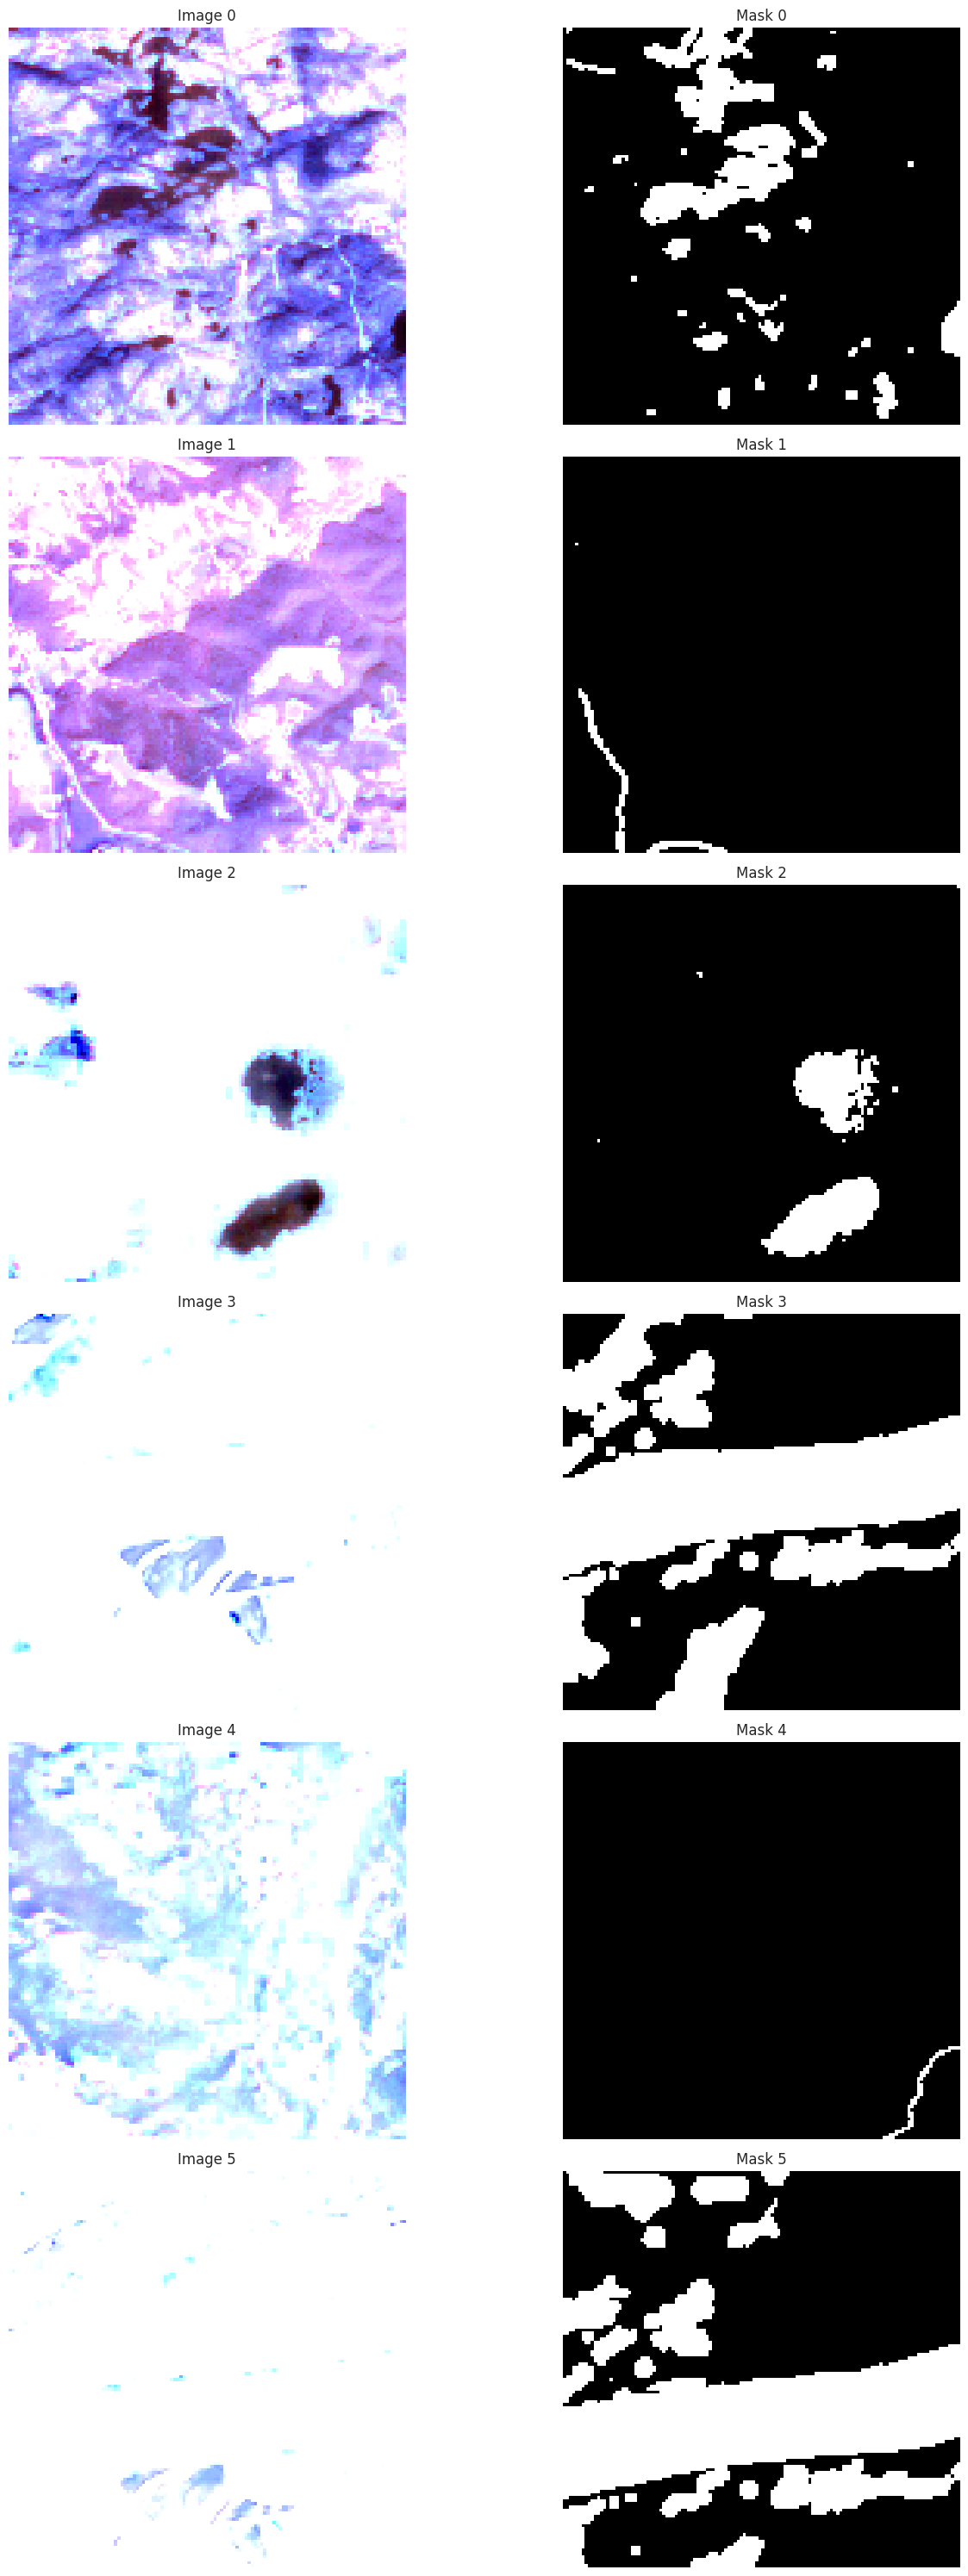

In [7]:
# Visualize a few image-mask pairs
def visualize_image_mask_pairs(df, num_samples=6):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # Load image and mask
        img_path = df['images'].iloc[i]
        mask_path = df['masks'].iloc[i]

        # Read image
        img = tiff.imread(img_path)
        # Read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Ensure the image is in RGB format for visualization
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] > 3:
            img = img[:, :, :3]

        # Plot image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title(f'Image {i}')
        plt.axis('off')

        # Plot mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_image_mask_pairs(df)

In [8]:
# Split the dataset
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

train, valid, test = split_df(df)
print(f"Training set: {len(train)} samples")
print(f"Validation set: {len(valid)} samples")
print(f"Test set: {len(test)} samples")

Training set: 244 samples
Validation set: 31 samples
Test set: 31 samples


# **Image Data Generator**

In [9]:
# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16

# Function to load and preprocess images and masks
def load_and_preprocess(img_path, mask_path, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    # Load .tif image using tifffile
    img = tiff.imread(img_path)
    if len(img.shape) == 2:  # Grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] > 3:  # Multi-band
        img = img[:, :, :3]  # Use first three bands (RGB)

    # Resize image
    img = cv2.resize(img, img_size)

    # Load .png mask using cv2
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)

    return img, mask

In [10]:
# Custom generator to handle .tif images and .png masks with augmentation
def create_gens(df, aug_dict, img_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE):
    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    while True:
        # Initialize batches
        batch_imgs = []
        batch_msks = []

        # Randomly select indices for the batch
        indices = np.random.permutation(len(df))[:batch_size]

        for idx in indices:
            img_path = df['images'].iloc[idx]
            mask_path = df['masks'].iloc[idx]

            img, mask = load_and_preprocess(img_path, mask_path, img_size)

            # Expand dimensions for mask to match augmentation requirements
            mask = np.expand_dims(mask, axis=-1)

            batch_imgs.append(img)
            batch_msks.append(mask)

        # Convert to arrays
        batch_imgs = np.array(batch_imgs, dtype=np.float32)
        batch_msks = np.array(batch_msks, dtype=np.float32)

        # Apply augmentation if aug_dict is not empty
        if aug_dict:
            # Augment images and masks together to ensure consistency
            for i in range(len(batch_imgs)):
                # Combine image and mask for synchronized augmentation
                combined = np.concatenate([batch_imgs[i], batch_msks[i]], axis=-1)
                combined = img_gen.random_transform(combined)
                # Split back into image and mask
                batch_imgs[i] = combined[:, :, :3]
                batch_msks[i] = combined[:, :, 3:]

        # Normalize images and masks
        batch_imgs = batch_imgs / 255.0
        batch_msks = batch_msks / 255.0
        batch_msks[batch_msks > 0.5] = 1
        batch_msks[batch_msks <= 0.5] = 0

        yield batch_imgs, batch_msks

# Define augmentation for training
tr_aug_dict = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create generators
train_gen = create_gens(train, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid, aug_dict={})
test_gen = create_gens(test, aug_dict={})

# **Model & Evaluation**

In [11]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder (Downsampling Path)
    # Block 1
    conv1 = Conv2D(64, (3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(64, (3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D((2, 2))(bn1)

    # Block 2
    conv2 = Conv2D(128, (3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(128, (3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D((2, 2))(bn2)

    # Block 3
    conv3 = Conv2D(256, (3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(256, (3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D((2, 2))(bn3)

    # Block 4
    conv4 = Conv2D(512, (3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(512, (3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D((2, 2))(bn4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(1024, (3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    # Decoder (Upsampling Path)
    # Block 6
    up6 = UpSampling2D((2, 2))(bn5)
    up6 = concatenate([up6, bn4])
    conv6 = Conv2D(512, (3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(512, (3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    # Block 7
    up7 = UpSampling2D((2, 2))(bn6)
    up7 = concatenate([up7, bn3])
    conv7 = Conv2D(256, (3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(256, (3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    # Block 8
    up8 = UpSampling2D((2, 2))(bn7)
    up8 = concatenate([up8, bn2])
    conv8 = Conv2D(128, (3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(128, (3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    # Block 9
    up9 = UpSampling2D((2, 2))(bn8)
    up9 = concatenate([up9, bn1])
    conv9 = Conv2D(64, (3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(64, (3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    model = Model(inputs, outputs)
    return model

In [12]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [13]:
model = unet()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,390,721 (119.75 MB)

 Trainable params: 31,384,833 (119.72 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [14]:
callbacks = [
    ModelCheckpoint('unet.h5', verbose=0, save_best_only=True),
    EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
    ]

history = model.fit(train_gen,
                    steps_per_epoch=len(train) // BATCH_SIZE,
                    epochs=40,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data = valid_gen,
                    validation_steps=len(valid) // BATCH_SIZE)

Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8144 - dice_coef: 3.4481e-04 - iou_coef: 3.4481e-04 - loss: -3.4481e-04

15/15 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step - accuracy: 0.8202 - dice_coef: 3.5409e-04 - iou_coef: 3.5409e-04 - loss: -3.5409e-04 - val_accuracy: 0.0446 - val_dice_coef: 1.0931e-04 - val_iou_coef: 1.0931e-04 - val_loss: -1.0931e-04
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.9651 - dice_coef: 7.5818e-04 - iou_coef: 7.5818e-04 - loss: -7.5818e-04 - val_accuracy: 0.0105 - val_dice_coef: 9.6033e-05 - val_iou_coef: 9.6033e-05 - val_loss: -9.6033e-05
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.9917 - dice_coef: 0.0012 - iou_coef: 0.0012 - loss: -0.0012

15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9919 - dice_coef: 0.0012 - iou_coef: 0.0012 - loss: -0.0012 - val_accuracy: 0.1534 - val_dice_coef: 1.0948e-04 - val_iou_coef: 1.0948e-04 - val_loss: -1.0948e-04
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.9916 - dice_coef: 0.0017 - iou_coef: 0.0017 - loss: -0.0017

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9916 - dice_coef: 0.0017 - iou_coef: 0.0017 - loss: -0.0017 - val_accuracy: 0.9230 - val_dice_coef: 3.9051e-04 - val_iou_coef: 3.9051e-04 - val_loss: -3.9051e-04
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.9976 - dice_coef: 0.0024 - iou_coef: 0.0024 - loss: -0.0024

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9977 - dice_coef: 0.0024 - iou_coef: 0.0024 - loss: -0.0024 - val_accuracy: 0.9986 - val_dice_coef: 9.0686e-04 - val_iou_coef: 9.0686e-04 - val_loss: -9.0686e-04
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 855ms/step - accuracy: 0.9875 - dice_coef: 0.0028 - iou_coef: 0.0028 - loss: -0.0028 - val_accuracy: 0.9113 - val_dice_coef: 6.1083e-04 - val_iou_coef: 6.1083e-04 - val_loss: -6.1083e-04
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.9986 - dice_coef: 0.0043 - iou_coef: 0.0043 - loss: -0.0043

15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9986 - dice_coef: 0.0043 - iou_coef: 0.0043 - loss: -0.0043 - val_accuracy: 0.9580 - val_dice_coef: 0.0012 - val_iou_coef: 0.0012 - val_loss: -0.0012
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.9988 - dice_coef: 0.0059 - iou_coef: 0.0059 - loss: -0.0059

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9989 - dice_coef: 0.0060 - iou_coef: 0.0060 - loss: -0.0060 - val_accuracy: 0.9997 - val_dice_coef: 0.0030 - val_iou_coef: 0.0030 - val_loss: -0.0030
Epoch 9/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.9995 - dice_coef: 0.0084 - iou_coef: 0.0084 - loss: -0.0084

15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9995 - dice_coef: 0.0084 - iou_coef: 0.0084 - loss: -0.0084 - val_accuracy: 0.9991 - val_dice_coef: 0.0043 - val_iou_coef: 0.0043 - val_loss: -0.0043
Epoch 10/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.9995 - dice_coef: 0.0115 - iou_coef: 0.0115 - loss: -0.0115

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9995 - dice_coef: 0.0115 - iou_coef: 0.0115 - loss: -0.0115 - val_accuracy: 1.0000 - val_dice_coef: 0.0064 - val_iou_coef: 0.0064 - val_loss: -0.0064
Epoch 11/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 872ms/step - accuracy: 0.9997 - dice_coef: 0.0158 - iou_coef: 0.0158 - loss: -0.0158 - val_accuracy: 0.9849 - val_dice_coef: 0.0046 - val_iou_coef: 0.0046 - val_loss: -0.0046
Epoch 12/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.9993 - dice_coef: 0.0194 - iou_coef: 0.0194 - loss: -0.0194

15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9993 - dice_coef: 0.0196 - iou_coef: 0.0196 - loss: -0.0196 - val_accuracy: 0.9990 - val_dice_coef: 0.0112 - val_iou_coef: 0.0112 - val_loss: -0.0112
Epoch 13/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.9998 - dice_coef: 0.0307 - iou_coef: 0.0307 - loss: -0.0307

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9998 - dice_coef: 0.0308 - iou_coef: 0.0308 - loss: -0.0308 - val_accuracy: 1.0000 - val_dice_coef: 0.0219 - val_iou_coef: 0.0219 - val_loss: -0.0219
Epoch 14/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.9999 - dice_coef: 0.0439 - iou_coef: 0.0439 - loss: -0.0439

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 980ms/step - accuracy: 0.9999 - dice_coef: 0.0441 - iou_coef: 0.0441 - loss: -0.0441 - val_accuracy: 1.0000 - val_dice_coef: 0.0324 - val_iou_coef: 0.0324 - val_loss: -0.0324
Epoch 15/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.9999 - dice_coef: 0.0593 - iou_coef: 0.0593 - loss: -0.0593

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9999 - dice_coef: 0.0596 - iou_coef: 0.0596 - loss: -0.0596 - val_accuracy: 1.0000 - val_dice_coef: 0.0542 - val_iou_coef: 0.0542 - val_loss: -0.0542
Epoch 16/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 1.0000 - dice_coef: 0.0878 - iou_coef: 0.0878 - loss: -0.0878

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 977ms/step - accuracy: 1.0000 - dice_coef: 0.0883 - iou_coef: 0.0883 - loss: -0.0883 - val_accuracy: 1.0000 - val_dice_coef: 0.0887 - val_iou_coef: 0.0887 - val_loss: -0.0887
Epoch 17/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 1.0000 - dice_coef: 0.1282 - iou_coef: 0.1282 - loss: -0.1282

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 980ms/step - accuracy: 1.0000 - dice_coef: 0.1290 - iou_coef: 0.1290 - loss: -0.1290 - val_accuracy: 1.0000 - val_dice_coef: 0.1371 - val_iou_coef: 0.1371 - val_loss: -0.1371
Epoch 18/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 1.0000 - dice_coef: 0.1835 - iou_coef: 0.1835 - loss: -0.1835

15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 1.0000 - dice_coef: 0.1845 - iou_coef: 0.1845 - loss: -0.1845 - val_accuracy: 1.0000 - val_dice_coef: 0.1956 - val_iou_coef: 0.1956 - val_loss: -0.1956
Epoch 19/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 1.0000 - dice_coef: 0.2535 - iou_coef: 0.2535 - loss: -0.2535

15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 1.0000 - dice_coef: 0.2545 - iou_coef: 0.2545 - loss: -0.2545 - val_accuracy: 1.0000 - val_dice_coef: 0.2661 - val_iou_coef: 0.2661 - val_loss: -0.2661
Epoch 20/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 1.0000 - dice_coef: 0.3323 - iou_coef: 0.3323 - loss: -0.3323

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 999ms/step - accuracy: 1.0000 - dice_coef: 0.3338 - iou_coef: 0.3338 - loss: -0.3338 - val_accuracy: 1.0000 - val_dice_coef: 0.3773 - val_iou_coef: 0.3773 - val_loss: -0.3773
Epoch 21/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 1.0000 - dice_coef: 0.4344 - iou_coef: 0.4344 - loss: -0.4344

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 1.0000 - dice_coef: 0.4352 - iou_coef: 0.4352 - loss: -0.4352 - val_accuracy: 1.0000 - val_dice_coef: 0.5218 - val_iou_coef: 0.5218 - val_loss: -0.5218
Epoch 22/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 1.0000 - dice_coef: 0.5308 - iou_coef: 0.5308 - loss: -0.5308

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 1.0000 - dice_coef: 0.5321 - iou_coef: 0.5321 - loss: -0.5321 - val_accuracy: 1.0000 - val_dice_coef: 0.5901 - val_iou_coef: 0.5901 - val_loss: -0.5901
Epoch 23/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 1.0000 - dice_coef: 0.6310 - iou_coef: 0.6310 - loss: -0.6310

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 967ms/step - accuracy: 1.0000 - dice_coef: 0.6325 - iou_coef: 0.6325 - loss: -0.6325 - val_accuracy: 1.0000 - val_dice_coef: 0.5990 - val_iou_coef: 0.5990 - val_loss: -0.5990
Epoch 24/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 1.0000 - dice_coef: 0.7179 - iou_coef: 0.7179 - loss: -0.7179

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 1.0000 - dice_coef: 0.7191 - iou_coef: 0.7191 - loss: -0.7191 - val_accuracy: 1.0000 - val_dice_coef: 0.7381 - val_iou_coef: 0.7381 - val_loss: -0.7381
Epoch 25/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 1.0000 - dice_coef: 0.7898 - iou_coef: 0.7898 - loss: -0.7898

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 1.0000 - dice_coef: 0.7906 - iou_coef: 0.7906 - loss: -0.7906 - val_accuracy: 1.0000 - val_dice_coef: 0.8006 - val_iou_coef: 0.8006 - val_loss: -0.8006
Epoch 26/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 1.0000 - dice_coef: 0.8370 - iou_coef: 0.8370 - loss: -0.8370

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 1.0000 - dice_coef: 0.8377 - iou_coef: 0.8377 - loss: -0.8377 - val_accuracy: 1.0000 - val_dice_coef: 0.8547 - val_iou_coef: 0.8547 - val_loss: -0.8547
Epoch 27/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 1.0000 - dice_coef: 0.8696 - iou_coef: 0.8696 - loss: -0.8696

15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 1.0000 - dice_coef: 0.8702 - iou_coef: 0.8702 - loss: -0.8702 - val_accuracy: 1.0000 - val_dice_coef: 0.8818 - val_iou_coef: 0.8818 - val_loss: -0.8818
Epoch 28/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 1.0000 - dice_coef: 0.8965 - iou_coef: 0.8965 - loss: -0.8965

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 966ms/step - accuracy: 1.0000 - dice_coef: 0.8968 - iou_coef: 0.8968 - loss: -0.8968 - val_accuracy: 1.0000 - val_dice_coef: 0.9000 - val_iou_coef: 0.9000 - val_loss: -0.9000
Epoch 29/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 1.0000 - dice_coef: 0.9164 - iou_coef: 0.9164 - loss: -0.9164

15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 1.0000 - dice_coef: 0.9165 - iou_coef: 0.9165 - loss: -0.9165 - val_accuracy: 1.0000 - val_dice_coef: 0.9208 - val_iou_coef: 0.9208 - val_loss: -0.9208
Epoch 30/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 1.0000 - dice_coef: 0.9279 - iou_coef: 0.9279 - loss: -0.9279

15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 1.0000 - dice_coef: 0.9280 - iou_coef: 0.9280 - loss: -0.9280 - val_accuracy: 1.0000 - val_dice_coef: 0.9284 - val_iou_coef: 0.9284 - val_loss: -0.9284
Epoch 31/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 1.0000 - dice_coef: 0.9389 - iou_coef: 0.9389 - loss: -0.9389

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 1.0000 - dice_coef: 0.9390 - iou_coef: 0.9390 - loss: -0.9390 - val_accuracy: 1.0000 - val_dice_coef: 0.9395 - val_iou_coef: 0.9395 - val_loss: -0.9395
Epoch 32/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 1.0000 - dice_coef: 0.9458 - iou_coef: 0.9458 - loss: -0.9458

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 979ms/step - accuracy: 1.0000 - dice_coef: 0.9459 - iou_coef: 0.9459 - loss: -0.9459 - val_accuracy: 1.0000 - val_dice_coef: 0.9477 - val_iou_coef: 0.9477 - val_loss: -0.9477
Epoch 33/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 1.0000 - dice_coef: 0.9517 - iou_coef: 0.9517 - loss: -0.9517

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 980ms/step - accuracy: 1.0000 - dice_coef: 0.9518 - iou_coef: 0.9518 - loss: -0.9518 - val_accuracy: 1.0000 - val_dice_coef: 0.9531 - val_iou_coef: 0.9531 - val_loss: -0.9531
Epoch 34/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 1.0000 - dice_coef: 0.9565 - iou_coef: 0.9565 - loss: -0.9565

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 1.0000 - dice_coef: 0.9566 - iou_coef: 0.9566 - loss: -0.9566 - val_accuracy: 1.0000 - val_dice_coef: 0.9574 - val_iou_coef: 0.9574 - val_loss: -0.9574
Epoch 35/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 1.0000 - dice_coef: 0.9607 - iou_coef: 0.9607 - loss: -0.9607

15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 1.0000 - dice_coef: 0.9607 - iou_coef: 0.9607 - loss: -0.9607 - val_accuracy: 1.0000 - val_dice_coef: 0.9630 - val_iou_coef: 0.9630 - val_loss: -0.9630
Epoch 36/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 1.0000 - dice_coef: 0.9648 - iou_coef: 0.9648 - loss: -0.9648

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 1.0000 - dice_coef: 0.9648 - iou_coef: 0.9648 - loss: -0.9648 - val_accuracy: 1.0000 - val_dice_coef: 0.9656 - val_iou_coef: 0.9656 - val_loss: -0.9656
Epoch 37/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 1.0000 - dice_coef: 0.9671 - iou_coef: 0.9671 - loss: -0.9671

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 1.0000 - dice_coef: 0.9671 - iou_coef: 0.9671 - loss: -0.9671 - val_accuracy: 1.0000 - val_dice_coef: 0.9680 - val_iou_coef: 0.9680 - val_loss: -0.9680
Epoch 38/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 1.0000 - dice_coef: 0.9704 - iou_coef: 0.9704 - loss: -0.9704

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 988ms/step - accuracy: 1.0000 - dice_coef: 0.9704 - iou_coef: 0.9704 - loss: -0.9704 - val_accuracy: 1.0000 - val_dice_coef: 0.9711 - val_iou_coef: 0.9711 - val_loss: -0.9711
Epoch 39/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 1.0000 - dice_coef: 0.9725 - iou_coef: 0.9725 - loss: -0.9725

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 1.0000 - dice_coef: 0.9725 - iou_coef: 0.9725 - loss: -0.9725 - val_accuracy: 1.0000 - val_dice_coef: 0.9733 - val_iou_coef: 0.9733 - val_loss: -0.9733
Epoch 40/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 1.0000 - dice_coef: 0.9744 - iou_coef: 0.9744 - loss: -0.9744

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 1.0000 - dice_coef: 0.9744 - iou_coef: 0.9744 - loss: -0.9744 - val_accuracy: 1.0000 - val_dice_coef: 0.9751 - val_iou_coef: 0.9751 - val_loss: -0.9751


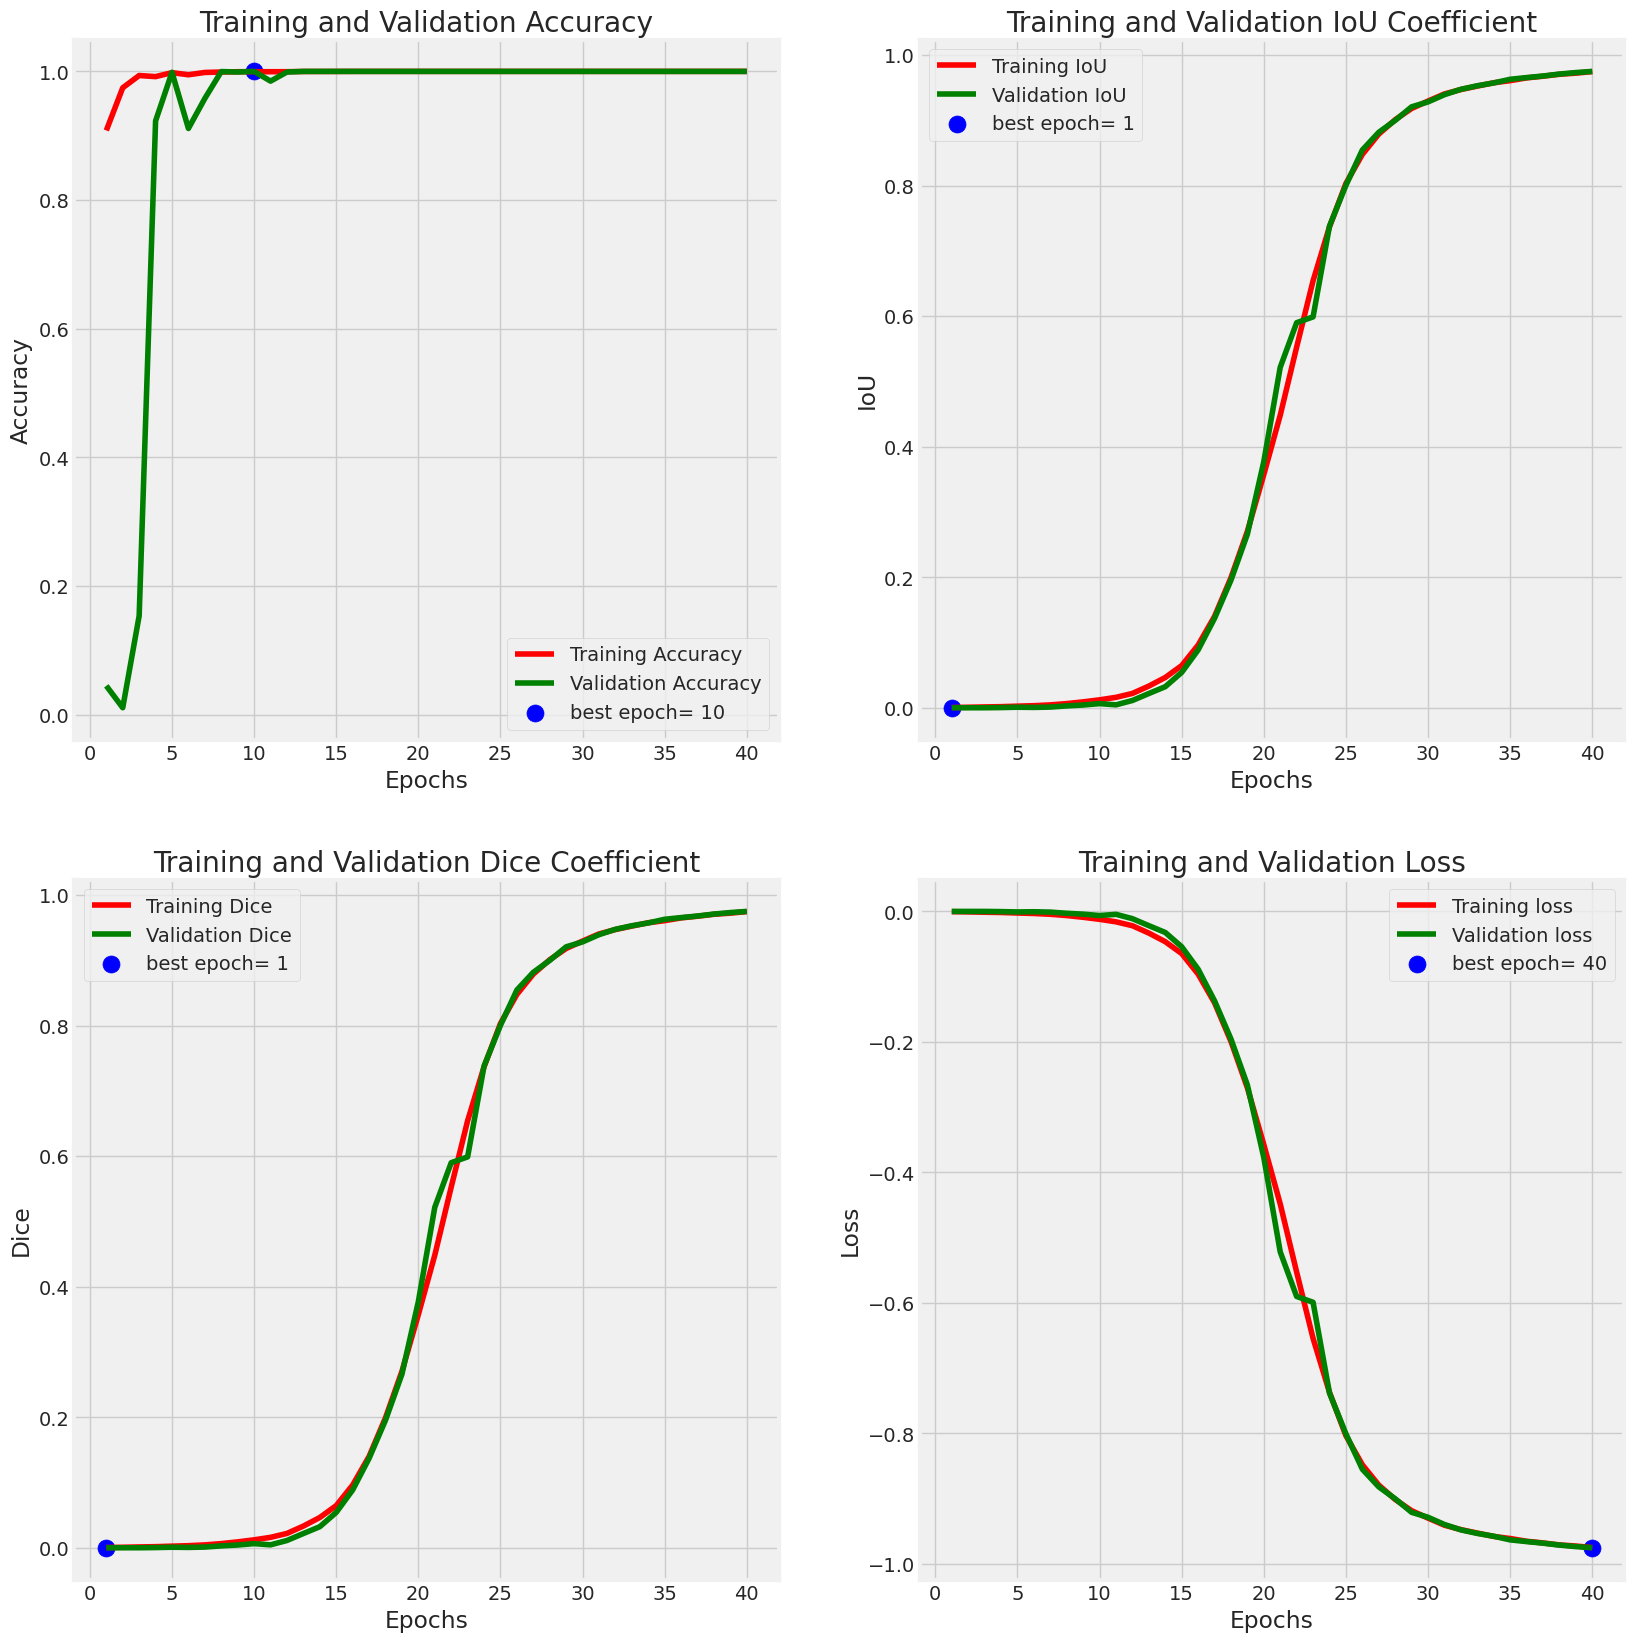

In [15]:
def plot_training(hist):
    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

plot_training(history)

In [16]:
ts_length = len(test)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 1.0000 - dice_coef: 0.9752 - iou_coef: 0.9752 - loss: -0.9752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 1.0000 - dice_coef: 0.9751 - iou_coef: 0.9751 - loss: -0.9751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 1.0000 - dice_coef: 0.9753 - iou_coef: 0.9753 - loss: -0.9753
Train Loss:  -0.9752166271209717
Train Accuracy:  1.0
Train IoU:  0.9752166271209717
Train Dice:  0.9752166271209717
--------------------
Valid Loss:  -0.9751058220863342
Valid Accuracy:  1.0
Valid IoU:  0.9751058220863342
Valid Dice:  0.9751058220863342
--------------------
Test Loss:  -0.9753130674362183
Test Accuracy:  1.0
Test IoU:  0.9753130674362183
Test Dice:  0.9753130674362183


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


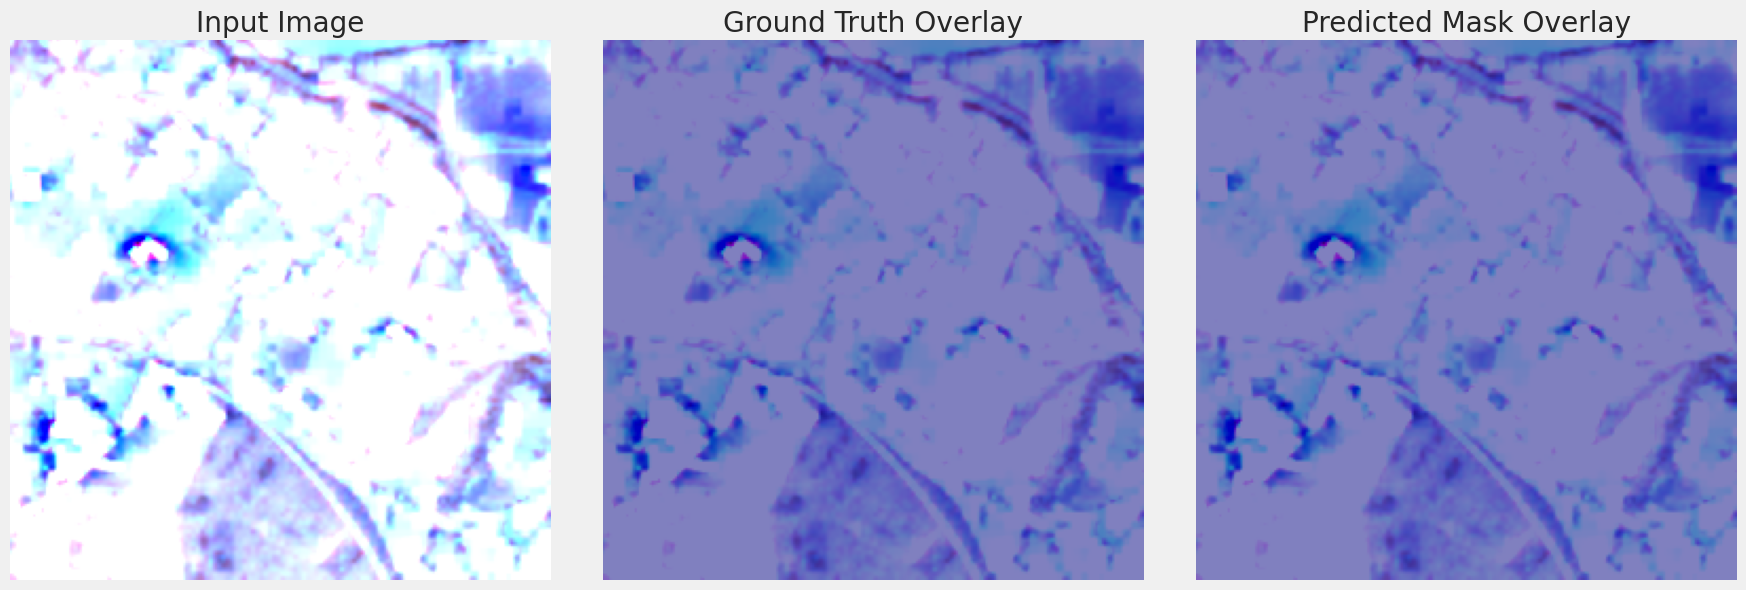

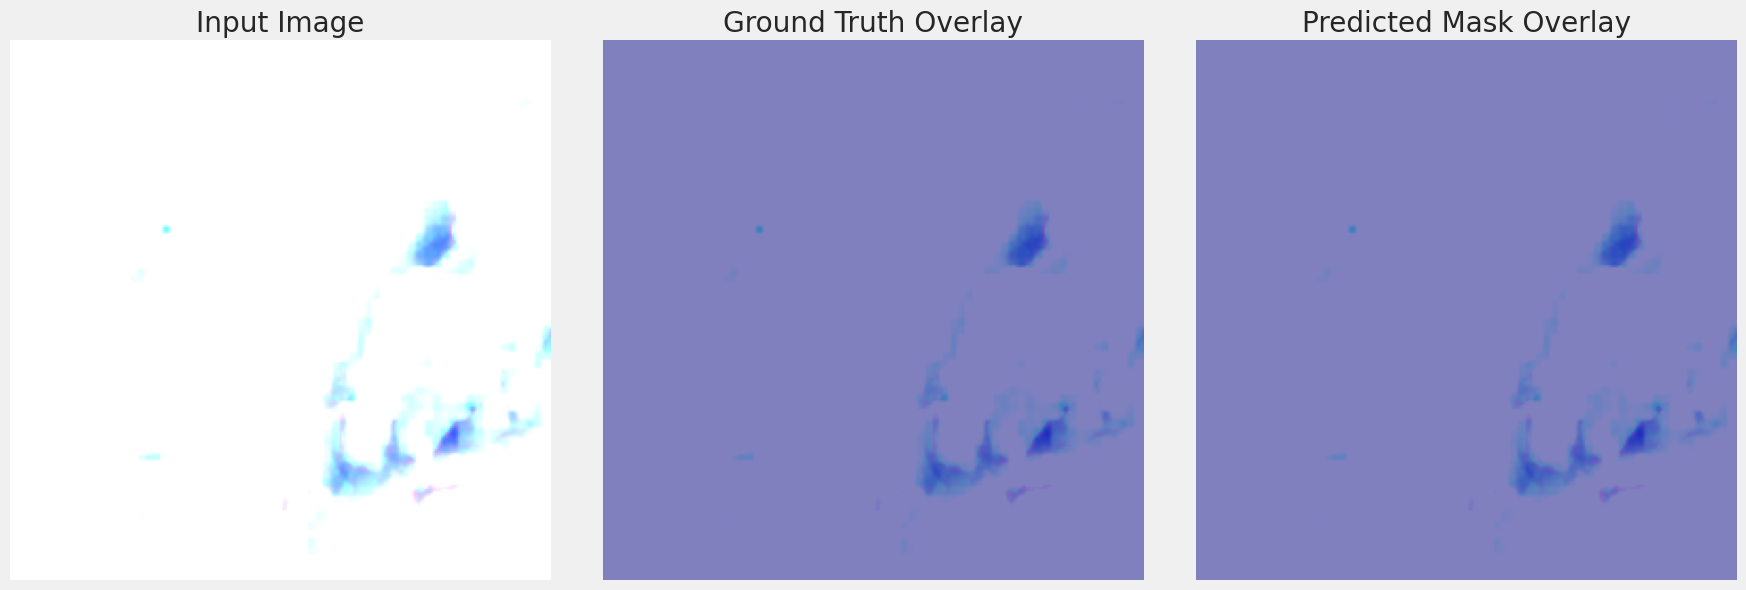

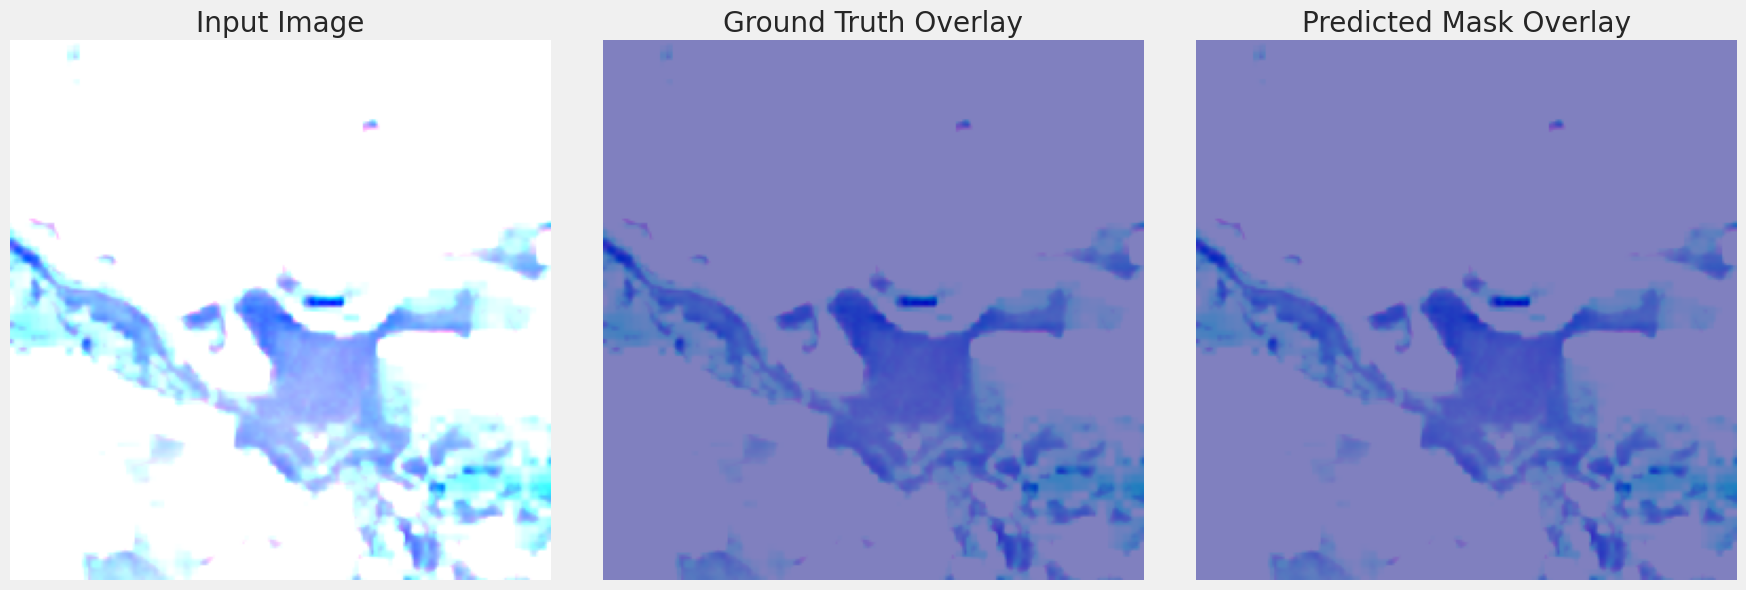

In [17]:
def overlay_predictions_with_ground_truth(model, generator, num_samples=3, alpha=0.5):
    # Get a batch from the generator
    images, masks = next(generator)

    # Predict masks
    predictions = model.predict(images)

    # Threshold predictions to binary [0, 1]
    predictions = (predictions > 0.5).astype(np.float32)

    for i in range(min(num_samples, len(images))):
        plt.figure(figsize=(18, 6))

        # Input image
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[i])
        plt.axis('off')

        # Ground truth overlay
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Overlay")
        plt.imshow(images[i])
        plt.imshow(masks[i].squeeze(), cmap='jet', alpha=alpha)
        plt.axis('off')

        # Predicted mask overlay
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask Overlay")
        plt.imshow(images[i])
        plt.imshow(predictions[i].squeeze(), cmap='jet', alpha=alpha)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Call the visualization function
overlay_predictions_with_ground_truth(model, test_gen)